In [1]:
!nvidia-smi

Mon Jul 25 15:49:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   55C    P5    20W / 170W |   1321MiB / 12050MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q ipywidgets --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org

In [3]:
import torch
import torchvision

torch.hub._validate_not_a_forked_repo=lambda a,b,c: True

resnet50_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
resnet50_model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
# # download images
# !mkdir -p ./data
# !wget  -O ./data/img0.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
# !wget  -O ./data/img1.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
# !wget  -O ./data/img2.JPG "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
# !wget  -O ./data/img3.JPG "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"

# !wget  -O ./data/imagenet_class_index.json "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

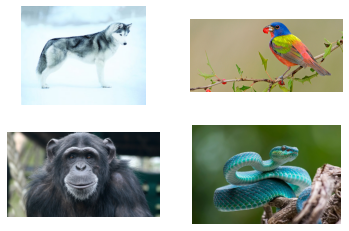

In [5]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import json

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = Image.open(img_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(img)
    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.axis('off')

# loading labels
with open("./data/imagenet_class_index.json") as json_file:
    d = json.load(json_file)

In [6]:
import numpy as np
import time
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

def rn50_preprocess():
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess

# decode the results into ([predicted class, description], probability)
def predict(img_path, model):
    img = Image.open(img_path)
    preprocess = rn50_preprocess()
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
        # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
        sm_output = torch.nn.functional.softmax(output[0], dim=0)

    ind = torch.argmax(sm_output)
    return d[str(ind.item())], sm_output[ind] #([predicted class, description], probability)

def benchmark(model, input_shape=(1024, 1, 224, 224), dtype='fp32', nwarmup=50, nruns=10000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()

    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output features size:", features.size())
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))

./data/img0.JPG - Predicted: ['n02110185', 'Siberian_husky'], Probablility: 0.4928709864616394
./data/img1.JPG - Predicted: ['n01820546', 'lorikeet'], Probablility: 0.6450998187065125
./data/img2.JPG - Predicted: ['n02481823', 'chimpanzee'], Probablility: 0.9903134107589722
./data/img3.JPG - Predicted: ['n01749939', 'green_mamba'], Probablility: 0.4305441975593567


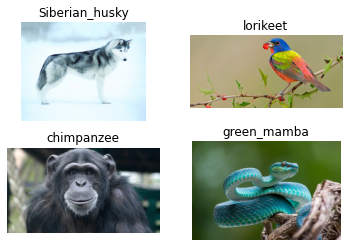

In [7]:
for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = Image.open(img_path)

    pred, prob = predict(img_path, resnet50_model)
    print('{} - Predicted: {}, Probablility: {}'.format(img_path, pred, prob))

    plt.subplot(2,2,i+1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(pred[1])

In [8]:
# Model benchmark without Torch-TensorRT
model = resnet50_model.eval().to("cuda")
benchmark(model, input_shape=(4, 3, 224, 224), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 10.91 ms
Iteration 20/100, ave batch time 10.96 ms
Iteration 30/100, ave batch time 10.90 ms
Iteration 40/100, ave batch time 10.80 ms
Iteration 50/100, ave batch time 10.74 ms
Iteration 60/100, ave batch time 10.71 ms
Iteration 70/100, ave batch time 10.68 ms
Iteration 80/100, ave batch time 10.67 ms
Iteration 90/100, ave batch time 10.65 ms
Iteration 100/100, ave batch time 10.64 ms
Input shape: torch.Size([4, 3, 224, 224])
Output features size: torch.Size([4, 1000])
Average batch time: 10.64 ms


In [9]:
import torch_tensorrt

# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP32 precision.
trt_model_fp32 = torch_tensorrt.compile(model, inputs = [torch_tensorrt.Input((4, 3, 224, 224), dtype=torch.float32)],
    enabled_precisions = torch.float32, # Run with FP32
    workspace_size = 1 << 22
)

In [10]:
# Obtain the average time taken by a batch of input
benchmark(trt_model_fp32, input_shape=(4, 3, 224, 224), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 5.85 ms
Iteration 20/100, ave batch time 5.84 ms
Iteration 30/100, ave batch time 5.83 ms
Iteration 40/100, ave batch time 5.81 ms
Iteration 50/100, ave batch time 5.83 ms
Iteration 60/100, ave batch time 5.82 ms
Iteration 70/100, ave batch time 5.82 ms
Iteration 80/100, ave batch time 5.82 ms
Iteration 90/100, ave batch time 5.83 ms
Iteration 100/100, ave batch time 5.82 ms
Input shape: torch.Size([4, 3, 224, 224])
Output features size: torch.Size([4, 1000])
Average batch time: 5.82 ms


In [14]:
import torch_tensorrt

# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP16 precision.
trt_model_fp16 = torch_tensorrt.compile(model, inputs = [torch_tensorrt.Input((4, 3, 224, 224), dtype=torch.float16)],
    enabled_precisions = torch.float16, # Run with FP16
    workspace_size = 1 << 22
)

In [ ]:
# Obtain the average time taken by a batch of input
benchmark(trt_model_fp16, input_shape=(4, 3, 224, 224), dtype='float16', nruns=100)

In [ ]:
c